<a href="https://colab.research.google.com/github/sudipta-on/Chaos_in_Skies/blob/main/Chaos_of_Skies_in_Thiruvananthapuram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# $$\textbf{Chaos in Skies: A chaotic analysis of meteorological parameters in Thiruvananthapuram, INDIA}$$


>This is the codes for the term paper submitted to Prof. Krishna Kumar in partial fulfillment of the course "Order & Chaos".
>
>Authors: Sudipta Majumder, Jyotinmoy Karmakar, Swarajit Dhar

In [17]:
# Required Module Installation
!pip install pyinform --quiet
!pip install git+https://github.com/manu-mannattil/nolitsa.git --quiet
!pip install tensorflow --quiet

  Preparing metadata (setup.py) ... done


## Time Series Plot

In [18]:
import numpy as np
import matplotlib.pyplot as plt

def Time_series_plot(dataset, target_parameters, labels, y_labels, title):
    '''
    Function to plot time series data for multiple parameters.

    Parameters:
    - dataset: DataFrame containing time series data.
    - target_parameters: List of column names to plot.
    - labels: List of labels corresponding to each target parameter.
    - y_labels: List of Y-axis labels corresponding to each target parameter.
    - title: Plot title.
    '''
    plt.figure(figsize=(16, 4 * len(target_parameters)))  # Single figure for all subplots

    for i, param in enumerate(target_parameters):
        plt.subplot(len(target_parameters), 1, i + 1)
        plt.plot(dataset.index, dataset[param], color='b', label=labels[i])
        plt.xlabel("Time (Days)")
        plt.ylabel(y_labels[i])
        plt.title(f"{title} {labels[i]}")

        # Setting x-axis ticks at an interval of 500 days
        num_days = len(dataset)  # Total number of days
        tick_positions = np.arange(0, num_days, 500)  # Every 500 days
        tick_labels = [str(pos) for pos in tick_positions]  # Only numbers, not dates

        plt.xticks(tick_positions, tick_labels)
        plt.grid(True)
        plt.legend()

    plt.tight_layout()  # Adjust layout for better spacing
    plt.show()


## Estimation of Delay Time

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from pyinform.mutualinfo import mutual_info
from scipy.signal import argrelextrema

def delay_time(dataset, target_parameter, max_lag=50, num_bins=100, graph=True):
    """
    Estimate the optimal time delay for phase space reconstruction
    using Average Mutual Information (AMI).

    Parameters:
    - dataset: DataFrame containing time series data.
    - target_parameter: Column name of the time series to analyze.
    - max_lag: Maximum lag to test (default: 50).
    - num_bins: Number of bins for discretization (default: 100).
    - graph: Whether to plot the AMI curve.

    Returns:
    - optimal_delay: Estimated optimal delay time.
    """

    # Extract and clean the time series
    time_series = dataset[target_parameter].dropna().values
    ami_values = []

    # Compute AMI for different lags
    for lag in range(1, max_lag + 1):
        x = time_series[:len(time_series) - lag]
        y = time_series[lag:]

        # Discretize the data (to prevent "negative state" errors)
        x_discrete = np.digitize(x, np.histogram(x, bins=num_bins)[1])
        y_discrete = np.digitize(y, np.histogram(y, bins=num_bins)[1])

        # Compute AMI
        ami_values.append(mutual_info(x_discrete.tolist(), y_discrete.tolist()))

    # Convert to NumPy array
    ami_values = np.array(ami_values)

    # Find local minima (potential optimal delay times)
    local_minima = argrelextrema(ami_values, np.less)[0]

    # Get the first local minimum as the optimal delay time
    optimal_delay = local_minima[0] + 1 if len(local_minima) > 0 else None

    if graph:
        # Plot AMI vs. Time Lag
        plt.figure(figsize=(8, 5))
        plt.plot(range(1, max_lag + 1), ami_values, marker='o', linestyle='-', label="AMI")
        plt.xlabel("Time Lag")
        plt.ylabel("Average Mutual Information")
        plt.title(f"AMI vs. Time Lag for {target_parameter.capitalize()}")
        plt.grid(True)

        # Highlight the optimal delay
        if optimal_delay:
            plt.axvline(optimal_delay, color='r', linestyle="--", label=f"Optimal Delay: {optimal_delay}")
            plt.scatter(optimal_delay, ami_values[optimal_delay - 1], color='red', s=100, label="First Local Min")

        plt.legend()
        plt.show()

    # Print and return the estimated delay time
    print(f"\nEstimated Optimal Delay Time for {target_parameter.capitalize()}: {optimal_delay}")
    return optimal_delay


## Embedding Dimension Estimation

In [20]:
from nolitsa import dimension  # Install with: pip install nolitsa

def embedding_dimension(dataset, target_parameter, optimal_delay, max_dim, graph=True, max_num=100,min_val=0.1):
    """
    Estimate the embedding dimension using the False Nearest Neighbors (FNN) algorithm.

    Parameters:
    - dataset: DataFrame containing time series data.
    - target_parameter: Column name of the time series.
    - optimal_delay: Delay time estimated using AMI.
    - max_dim: Maximum embedding dimension to test.
    - graph: Whether to plot the FNN percentage graph.

    Returns:
    - optimal_dim: The estimated minimum embedding dimension where FNN% drops below 0.1%.
    """
    time_series = dataset[target_parameter].dropna().values
    dims = np.arange(1, max_dim + 1)
    # Compute false nearest neighbors
    fnn_values = dimension.fnn(time_series, tau=optimal_delay, dim=dims, maxnum=max_num)
    fnn_percent = fnn_values[0, :] * 100  # Use only the first row
    optimal_dim = None  # Default value

    if graph:
        # Plot FNN% vs. Embedding Dimension
        plt.figure(figsize=(8, 5))
        plt.plot(dims, fnn_percent, marker='o', linestyle='-', color='b', label="FNN%")
        plt.xlabel("Embedding Dimension")
        plt.ylabel("False Nearest Neighbors (%)")
        plt.title("False Nearest Neighbors vs. Embedding Dimension")
        plt.grid(True)
        # Mark the optimal dimension where FNN% < 1
        optimal_dim_idx = np.where(fnn_percent < min_val)[0]  # Find indices where FNN% < 0.1
        if optimal_dim_idx.size > 0:
            optimal_dim = optimal_dim_idx[0] + 1  # Convert index to embedding dimension
            plt.axvline(optimal_dim, color='r', linestyle="--", label=f"Optimal Dimension: {optimal_dim}")
            plt.scatter(optimal_dim, fnn_percent[optimal_dim - 1], color='red', s=100, label=f"First Drop Below {min_val}%")
        else:
            optimal_dim = None

        plt.legend()
        plt.show()
    # Print the estimated embedding dimension
    if optimal_dim:
        print(f"Estimated Optimal Embedding Dimension: {optimal_dim}")
    else:
        print("No embedding dimension found where FNN% drops below 0.1%. Consider increasing max_dim.")

    return optimal_dim

## Phase Space Reconstruction

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def phase_space_reconstruction(time_series, tau, m):
    """
    Reconstructs the phase space of a time series using time delay embedding.

    Parameters:
    - time_series: 1D NumPy array of the time series.
    - tau: Optimal delay (from AMI analysis).
    - m: Optimal embedding dimension (from FNN analysis).

    Returns:
    - None (Displays a 2D or 3D phase space plot).
    """
    # Ensure parameters are valid
    if tau <= 0 or m <= 0:
        raise ValueError("tau and m must be positive integers.")

    # Compute the number of valid points
    N = len(time_series) - (m - 1) * tau
    if N <= 0:
        raise ValueError("Embedding parameters (tau, m) result in insufficient data for reconstruction.")

    # Construct the embedded data matrix
    embedded_data = np.array([time_series[i:N + i] for i in range(0, m * tau, tau)]).T

    # Plot the reconstructed phase space
    fig = plt.figure(figsize=(6, 6))

    if m >= 3:
        # 3D Phase Space
        ax = fig.add_subplot(111, projection='3d')
        ax.plot(embedded_data[:, 0], embedded_data[:, 1], embedded_data[:, 2], color='b', alpha=0.7)
        ax.set_xlabel('x(t)')
        ax.set_ylabel(f'x(t + τ)')
        ax.set_zlabel(f'x(t + 2τ)')
        ax.set_title("3D Reconstructed Phase Space")
    else:
        # 2D Phase Space
        plt.plot(embedded_data[:, 0], embedded_data[:, 1], color='b', alpha=0.7)
        plt.xlabel('x(t)')
        plt.ylabel(f'x(t + τ)')
        plt.title("2D Reconstructed Phase Space")
        plt.grid(True)

    plt.show()

## Poincare Plot

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
def poincare_plot(time_series, tau):
    """
    Plots Pincare plot of a time series.

    Parameters:
    - time_series: 1D NumPy array of the time series.
    - tau: Optimal delay (from AMI analysis).

    Returns:
    - None (Displays a Poincaré plot).
    """
    # Construct Poincaré plot (x(t) vs. x(t+τ))
    x_t = time_series[:-tau]
    x_t_tau = time_series[tau:]

    # Plot the Poincaré map
    plt.figure(figsize=(6,6))
    plt.scatter(x_t, x_t_tau, s=5, alpha=0.5, color='blue')
    plt.xlabel("$x(t)$")
    plt.ylabel("$x(t+\\tau)$")
    plt.title(f"Poincaré Plot for {label} Data")
    plt.grid(True)
    # Optional: Add a y=x reference line
    x_min, x_max = min(x_t), max(x_t)
    plt.plot([x_min, x_max], [x_min, x_max], 'r--', linewidth=1)

    plt.show()


## Recurrence Plot

In [23]:
import scipy.spatial.distance as ssd

def recurrence_plot(time_series, epsilon=0.1, title="Recurrence Plot"):
    """
    Generates a recurrence plot for a given time series.

    Parameters:
        time_series (array): The 1D time series data.
        epsilon (float): Threshold for recurrence (distance metric).
        title (str): Plot title.
    """
    N = len(time_series)

    # Compute the pairwise distance matrix
    dist_matrix = ssd.squareform(ssd.pdist(time_series.reshape(-1, 1), metric='euclidean'))

    # Create recurrence matrix (1 if distance < epsilon, else 0)
    rec_matrix = dist_matrix < epsilon

    # Plot the recurrence plot
    plt.figure(figsize=(6, 6))
    plt.imshow(rec_matrix, cmap="binary", origin="lower")
    plt.title(title)
    plt.xlabel("Time Step")
    plt.ylabel("Time Step")
    plt.show()

## Forcasting

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from rich.console import Console
from rich.table import Table

# Initialize Console for Rich Display
console = Console()

def weather_forecasting(df, target_column, y_label, prediction_days=30, time_steps=60, test_size=0.2, lstm_epochs=50, plot_days=100):
    """
    Function to train and compare multiple weather prediction models (LSTM, ARIMA, Random Forest, XGBoost).

    Parameters:
    - df: DataFrame containing the dataset
    - target_column: Column name of the target variable
    - prediction_days: Number of days to predict (default: 30)
    - time_steps: Number of past days to use for prediction (default: 60)
    - test_size: Fraction of data used for testing (default: 0.2)
    - lstm_epochs: Number of epochs for LSTM training (default: 50)
    - plot_days: Number of days (historical + predicted) to visualize in the plot (default: 100)
    """
    # Extract target variable and remove NaNs
    data_series = df[target_column].dropna().values.reshape(-1, 1)

    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data_series)

    # Create sequences for LSTM input
    X, y = [], []
    for i in range(len(scaled_data) - time_steps):
        X.append(scaled_data[i:i+time_steps])
        y.append(scaled_data[i+time_steps])

    X, y = np.array(X), np.array(y)

    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)

    # ------------------------ LSTM Model ------------------------
    lstm_model = Sequential([
        LSTM(100, activation='relu', return_sequences=True, input_shape=(time_steps, 1)),
        Dropout(0.2),
        LSTM(50, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])

    lstm_model.compile(optimizer='adam', loss='mse')
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    lstm_model.fit(X_train, y_train, epochs=lstm_epochs, batch_size=16, validation_data=(X_test, y_test),
                   callbacks=[early_stopping], verbose=1)

    lstm_pred = lstm_model.predict(X_test)
    lstm_pred = scaler.inverse_transform(lstm_pred)
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

    # ------------------------ Random Forest ------------------------
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train.reshape(X_train.shape[0], -1), y_train.ravel())
    rf_pred = rf_model.predict(X_test.reshape(X_test.shape[0], -1))
    rf_pred = scaler.inverse_transform(rf_pred.reshape(-1, 1))

    # ------------------------ XGBoost ------------------------
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
    xgb_model.fit(X_train.reshape(X_train.shape[0], -1), y_train.ravel())
    xgb_pred = xgb_model.predict(X_test.reshape(X_test.shape[0], -1))
    xgb_pred = scaler.inverse_transform(xgb_pred.reshape(-1, 1))

    # ------------------------ Compute Errors ------------------------
    def compute_errors(actual, predicted):
        mae = mean_absolute_error(actual, predicted)
        rmse = np.sqrt(mean_squared_error(actual, predicted))
        return mae, rmse

    errors = {
        "LSTM": compute_errors(y_test_actual, lstm_pred),
        "Random Forest": compute_errors(y_test_actual, rf_pred),
        "XGBoost": compute_errors(y_test_actual, xgb_pred),
    }

    # ------------------------ Display Results in Rich Table ------------------------
    table = Table(title=f"Model Comparison for {prediction_days}-Day Prediction")
    table.add_column("Model", justify="left", style="cyan", no_wrap=True)
    table.add_column("MAE", justify="right", style="magenta")
    table.add_column("RMSE", justify="right", style="yellow")

    for model, (mae, rmse) in errors.items():
        table.add_row(model, f"{mae:.4f}", f"{rmse:.4f}")

    console.print(table)

    # ------------------------ Plot Predictions ------------------------
    total_data_points = len(y_test_actual)
    plot_range = min(plot_days, total_data_points)

    plt.figure(figsize=(12, 5))
    plt.plot(y_test_actual[-plot_range:], label="Actual", color='black')
    plt.plot(lstm_pred[-plot_range:], label="LSTM", color='red', linestyle="dashed")
    plt.plot(rf_pred[-plot_range:], label="Random Forest", color='green', linestyle="dashed")
    plt.plot(xgb_pred[-plot_range:], label="XGBoost", color='orange', linestyle="dashed")
    plt.title(f"Weather Forecasting: Actual vs Predicted ({prediction_days}-Day)")
    plt.xlabel("Time Steps")
    plt.ylabel(y_label)
    plt.legend()
    plt.grid()
    plt.show()

    return errors

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

def time_delay_embedding(series, m, tau):
    """Construct time-delay embedding vectors."""
    N = len(series) - (m - 1) * tau
    return np.array([series[i: i + N] for i in range(0, m * tau, tau)]).T

def compute_lyapunov_exponent_wolf(series, m=3, tau=2, t_max=50, epsilon=1e-5):
    """
    Compute the Largest Lyapunov Exponent (LLE) using Wolf's method.

    Parameters:
        series (numpy array): 1D time series data.
        m (int): Embedding dimension.
        tau (int): Time delay.
        t_max (int): Maximum evolution time.
        epsilon (float): Threshold for divergence.

    Returns:
        lambda_max (float): Estimated LLE.
    """
    # Step 1: Time-delay embedding
    embedded_data = time_delay_embedding(series, m, tau)
    N = len(embedded_data)

    # Step 2: Compute pairwise distances to find nearest neighbors
    dists = cdist(embedded_data, embedded_data)
    np.fill_diagonal(dists, np.inf)  # Ignore self-distances
    nearest_neighbors = np.argmin(dists, axis=1)  # Find nearest neighbors

    # Step 3: Track separation over time
    divergence = []
    ref_indices = np.arange(N - t_max)  # Reference points
    neighbor_indices = nearest_neighbors[ref_indices]  # Corresponding nearest neighbors

    for t in range(1, t_max):
        # Ensure valid indices
        valid_indices = ref_indices[(neighbor_indices < N - t) & (ref_indices < N - t)]

        if len(valid_indices) == 0:
            break

        # Compute distances between evolved neighbors
        distances = np.linalg.norm(
            embedded_data[valid_indices + t] - embedded_data[neighbor_indices[valid_indices] + t], axis=1
        )
        distances = distances[distances > epsilon]  # Ignore too small distances
        if len(distances) == 0:
            break

        divergence.append(np.mean(np.log(distances)))

        # Resetting nearest neighbor if it diverges too much
        neighbor_indices[valid_indices] = np.argmin(
            cdist(embedded_data[valid_indices + t], embedded_data), axis=1
        )

    # Step 4: Fit Lyapunov Exponent from linear region
    divergence = np.array(divergence)
    valid_divergence = divergence[divergence > 0]
    if len(valid_divergence) < 10:  # Ensure enough data points
        print("Warning: Not enough valid divergence values for reliable fitting.")
        return None

    # Select region for linear fit (e.g., between steps 5-20)
    linear_fit_range = slice(5, min(40, len(valid_divergence)))
    t_values = np.arange(len(divergence))[linear_fit_range]
    divergence_values = valid_divergence[linear_fit_range]

    if len(divergence_values) < 2:  # Ensure at least 2 points for fitting
        print("Warning: Insufficient data points for linear regression.")
        return None

    # Linear regression to get LLE
    coeffs = np.polyfit(t_values, divergence_values, 1)
    lambda_max = coeffs[0]  # Slope gives LLE

    # Step 5: Plot the results
    plt.figure(figsize=(8, 5))
    plt.plot(np.arange(len(divergence)), divergence, marker='*', linestyle='-', color='red', label="Log Divergence")
    plt.plot(t_values, coeffs[0] * t_values + coeffs[1], linestyle="--", color="blue",
             label=f"Fit: λ ≈ {lambda_max:.4f}")
    plt.xlabel("Time Steps")
    plt.ylabel("ln(divergence)")
    plt.title("Largest Lyapunov Exponent Estimation (Wolf's Method)")
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"Estimated Largest Lyapunov Exponent: {lambda_max:.4f}")
    return lambda_max

In [26]:
import numpy as np
import matplotlib.pyplot as plt

def compute_hurst_exponent(time_series, max_lag=100):
    """
    Compute the Hurst Exponent using the R/S (Rescaled Range) method.

    Parameters:
        time_series (numpy array): 1D time series data.
        max_lag (int): Maximum lag to compute R/S values.

    Returns:
        lags (numpy array): Time lags (including 0).
        R_S_values (numpy array): R/S values (including 0).
        H (float): Estimated Hurst exponent.
    """
    N = len(time_series)
    lags = np.logspace(1, np.log10(min(max_lag, N // 2)), num=100, dtype=int)  # Log-spaced lags
    R_S_values = []

    for lag in lags:
        segments = N // lag
        R_S_list = []

        for i in range(segments):
            segment = time_series[i * lag: (i + 1) * lag]
            mean_adjusted = segment - np.mean(segment)
            cumulative_dev = np.cumsum(mean_adjusted)
            R = np.max(cumulative_dev) - np.min(cumulative_dev)  # Range (R)
            S = np.std(segment)  # Standard deviation (S)

            if S > 0:
                R_S_list.append(R / S)

        if R_S_list:
            R_S_values.append(np.mean(R_S_list))
        else:
            R_S_values.append(np.nan)  # Handle division by zero

    # Convert to numpy arrays and remove NaN values
    lags, R_S_values = np.array(lags), np.array(R_S_values)
    valid_indices = ~np.isnan(R_S_values)
    lags, R_S_values = lags[valid_indices], R_S_values[valid_indices]

    # Add (0,0) manually for plotting
    lags = np.insert(lags, 0, 1)
    R_S_values = np.insert(R_S_values, 0, 1)

    # Compute log values
    log_lags, log_R_S = np.log(lags), np.log(R_S_values)

    # Estimate Hurst exponent (H) using least squares fit on log-log scale
    coeffs = np.polyfit(log_lags[1:], log_R_S[1:], 1)  # Skip (0,0) for fitting
    H = coeffs[0]  # Slope gives H

    return log_lags, log_R_S, H

def plot_hurst_exponent(log_lags, log_R_S, H):
    """
    Plot the Hurst Exponent estimation using a log-log scatter plot.

    Parameters:
        log_lags (numpy array): Log values of time lags (including 0).
        log_R_S (numpy array): Log values of R/S values (including 0).
        H (float): Estimated Hurst exponent.
    """
    plt.figure(figsize=(8, 5))

    # Scatter plot for computed log(R/S) values
    plt.scatter(log_lags, log_R_S, color='blue', s=5, label=f"Empirical R/S (H ≈ {H:.6f})")

    # Reference lines with slopes 0.5 and 1.0 starting from (0,0)
    x_ref = np.linspace(0, log_lags[-1], 100)  # Smooth reference line
    y_ref_05 = 0.5 * x_ref  # Slope = 0.5 (Brownian Motion)
    y_ref_1 = x_ref  # Slope = 1.0 (Persistent)

    plt.plot(x_ref, y_ref_05, 'r--', label="Slope 0.5 (Brownian Motion)")
    plt.plot(x_ref, y_ref_1, 'g--', label="Slope 1.0 (Persistent)")

    # Labels and title
    plt.xlabel("log(Time Lag)")
    plt.ylabel("log(R/S)")
    plt.title("Hurst Exponent Estimation using Log-Log Scatter Plot")
    plt.legend()
    plt.grid(True, linestyle="--")

    # Ensure axes start from (0,0)
    plt.xlim(0, None)
    plt.ylim(0, None)

    plt.show()


## Loading Dataset

In [27]:
import pandas as pd

# Load dataset from Google Sheets
sheet_url = "https://docs.google.com/spreadsheets/d/1u5f8HZko1IX8FH_5uprZdKY4beHjOIqdOuJhXXZQLLI/export?format=csv"

df = pd.read_csv(sheet_url)

# Set datetime as index for plotting
df.set_index('Date', inplace=True)

# Display the first few rows
df.head()

,Place,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
Date,,,,,,,,,,,,,,,,,,,,,
01/1/15,Thiruvananthapuram,32.1,23.9,27.5,39.3,23.9,30.0,23.7,80.4,1.513,...,19.2,8,NaN,2015-01-01 6:36:27,2015-01-01 18:14:39,0.36,"Rain, Partially cloudy",Partly cloudy throughout the day with morning ...,🌧️,"43371099999,remote,43372099999"
02/1/15,Thiruvananthapuram,31.7,21.1,26.6,36.7,21.1,28.1,21.6,75.0,0.000,...,22.1,9,NaN,2015-01-02 6:36:52,2015-01-02 18:15:10,0.40,Partially cloudy,Partly cloudy throughout the day.,⛅,"43371099999,remote,43372099999"
03/1/15,Thiruvananthapuram,31.0,21.7,26.8,36.7,21.7,28.6,21.5,73.6,0.000,...,22.2,9,NaN,2015-01-03 6:37:16,2015-01-03 18:15:42,0.43,Partially cloudy,Partly cloudy throughout the day.,⛅,##########
04/1/15,Thiruvananthapuram,31.0,23.1,27.2,37.9,23.1,29.5,22.9,78.4,0.000,...,21.8,9,NaN,2015-01-04 6:37:39,2015-01-04 18:16:13,0.47,Partially cloudy,Partly cloudy throughout the day.,⛅,"43371099999,remote,43372099999"
05/1/15,Thiruvananthapuram,31.2,24.1,27.6,36.7,24.1,30.0,22.9,76.3,0.000,...,21.6,9,NaN,2015-01-05 6:38:02,2015-01-05 18:16:45,0.50,Partially cloudy,Partly cloudy throughout the day.,⛅,"43371099999,remote,43372099999"


### For Temperature

In [28]:
param = 'temp'
label = 'Temperature'
y_label = 'Air Temperature (˚C)'
time_series = df[param].dropna().values

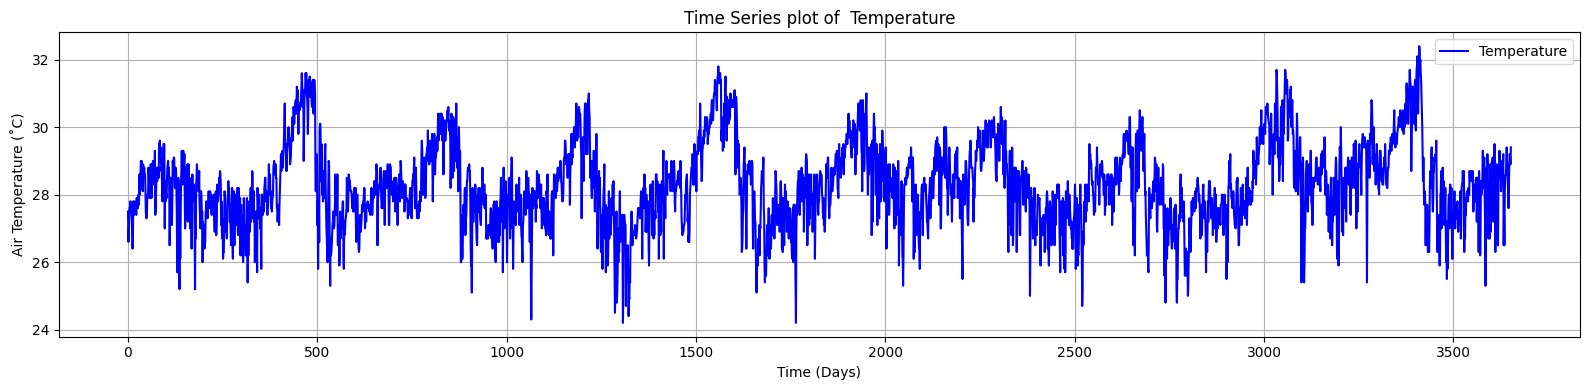

In [29]:
# Time series plot
Time_series_plot(dataset=df,
                 target_parameters=[param],
                 labels=[label],
                 y_labels=[y_label],
                 title='Time Series plot of ')

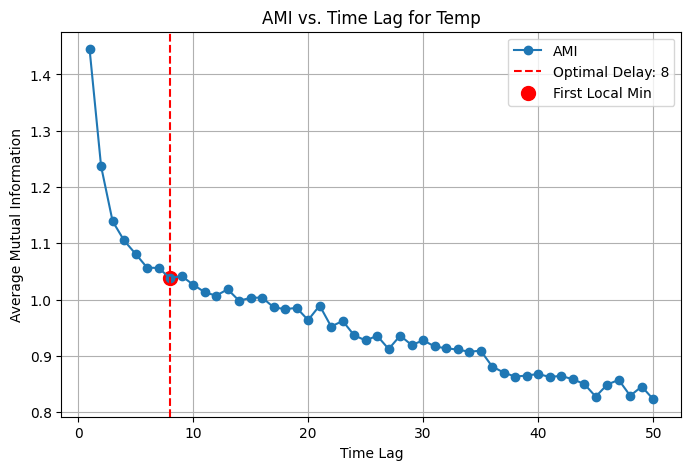


Estimated Optimal Delay Time for Temp: 8


In [30]:
# Delay Time Estimation
temp_optimal_tau = delay_time(df, param, max_lag=50)

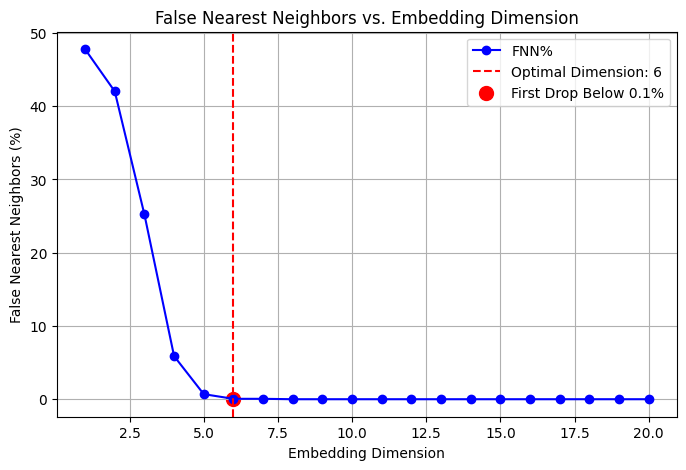

Estimated Optimal Embedding Dimension: 6


In [31]:
# Embedding Dimension Estimation
temp_optimal_m = embedding_dimension(df, param, temp_optimal_tau, max_dim=20,max_num=1000,min_val=0.1)

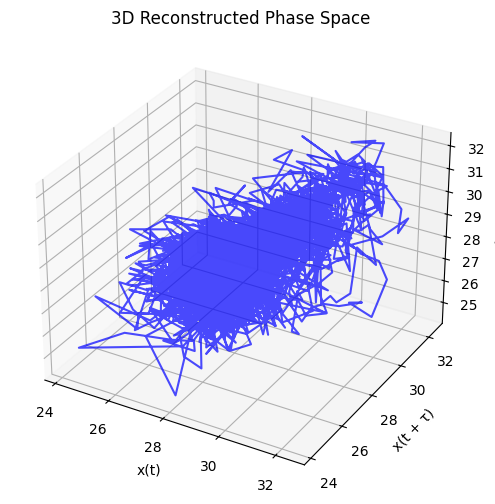

In [32]:
phase_space_reconstruction(time_series, temp_optimal_tau, temp_optimal_m)

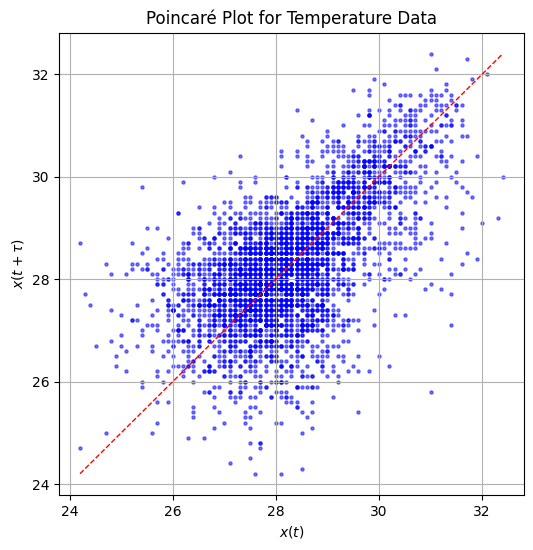

In [33]:
poincare_plot(time_series, temp_optimal_tau)

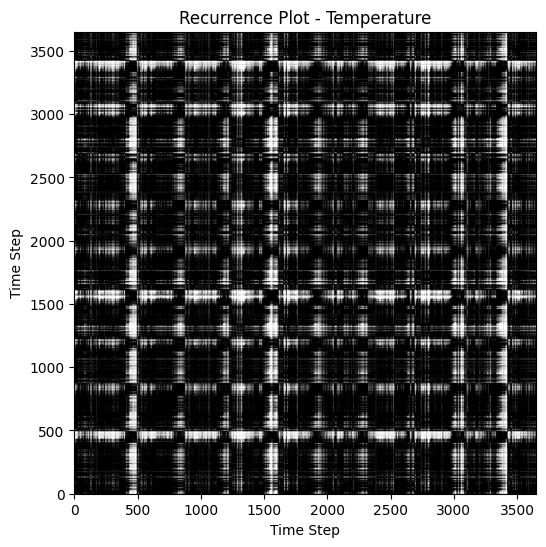

In [34]:
# Generate recurrence plots for each weather parameter
recurrence_plot(time_series, epsilon=2.5, title=f"Recurrence Plot - {label}")

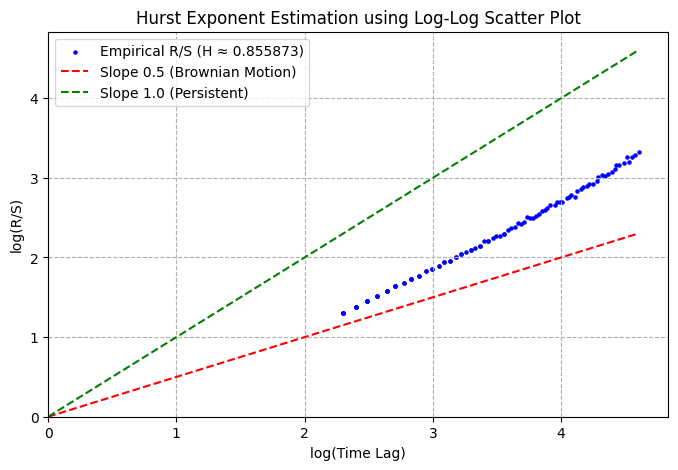

Estimated Hurst Exponent: 0.8559


In [35]:
# Compute Hurst exponent
log_lags, log_R_S, temp_H = compute_hurst_exponent(time_series)

# Plot the results
plot_hurst_exponent(log_lags, log_R_S, temp_H)

print(f"Estimated Hurst Exponent: {temp_H:.4f}")

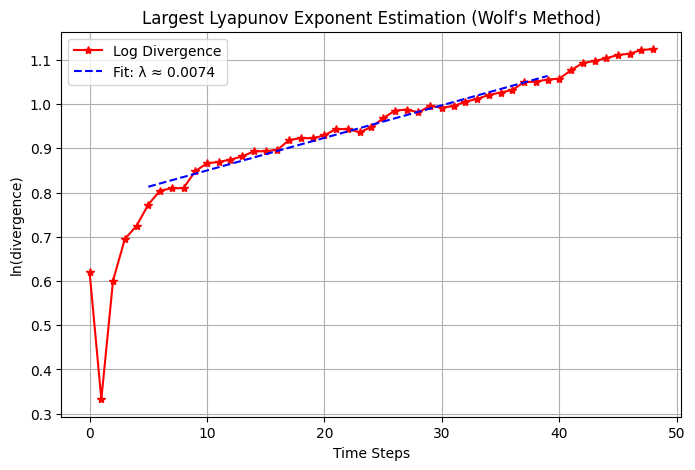

Estimated Largest Lyapunov Exponent: 0.0074


In [36]:
temp_lambda_max = compute_lyapunov_exponent_wolf(time_series, tau=temp_optimal_tau, m=temp_optimal_m, t_max=50)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 17s 70ms/step - loss: 0.0559 - val_loss: 0.0115
Epoch 2/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 19s 64ms/step - loss: 0.0138 - val_loss: 0.0114
Epoch 3/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - loss: 0.0128 - val_loss: 0.0107
Epoch 4/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - loss: 0.0110 - val_loss: 0.0100
Epoch 5/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 22s 70ms/step - loss: 0.0116 - val_loss: 0.0108
Epoch 6/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step - loss: 0.0111 - val_loss: 0.0107
Epoch 7/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 19s 66ms/step - loss: 0.0110 - val_loss: 0.0098
Epoch 8/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - loss: 0.0107 - val_loss: 0.0092
Epoch 9/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - loss: 0.0102 - val_loss: 0.0089
Epoch 10/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 22s 69ms/step - loss: 0.0092 - val_loss: 0.0101
Epoch 11/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 20s 67ms/step - loss: 0.0093 - val_loss: 0.0086
Epoch 12/50
180/180 ━━━━━━━━━━

    Model Comparison for 30-Day    
            Prediction             
┏━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┓
┃ Model         ┃    MAE ┃   RMSE ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━┩
│ LSTM          │ 0.5039 │ 0.6728 │
│ Random Forest │ 0.5189 │ 0.6802 │
│ XGBoost       │ 0.5786 │ 0.7639 │
└───────────────┴────────┴────────┘

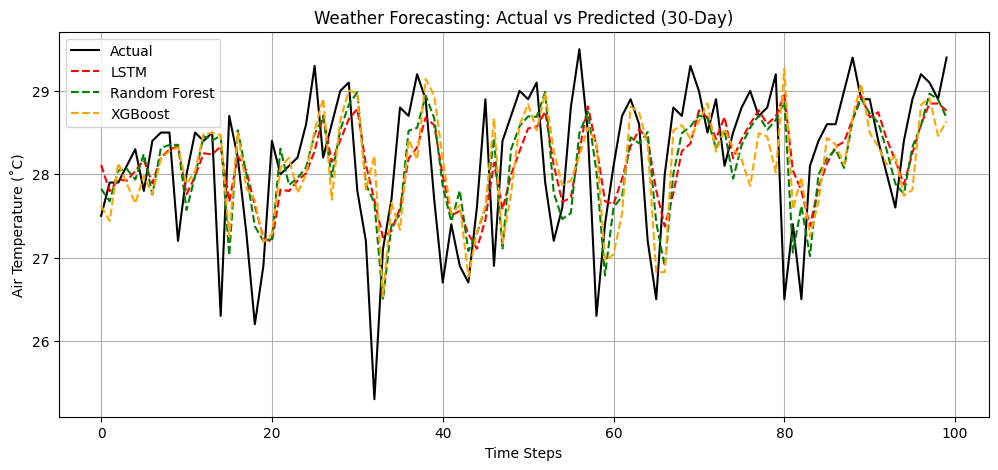

In [37]:
pred_30 = weather_forecasting(df, target_column=param,y_label=y_label, prediction_days=30, plot_days=100)

### For Humidity

In [38]:
param = 'humidity'
label = 'Humidity'
y_label = 'Relative Humidity (%)'
time_series = df[param].dropna().values

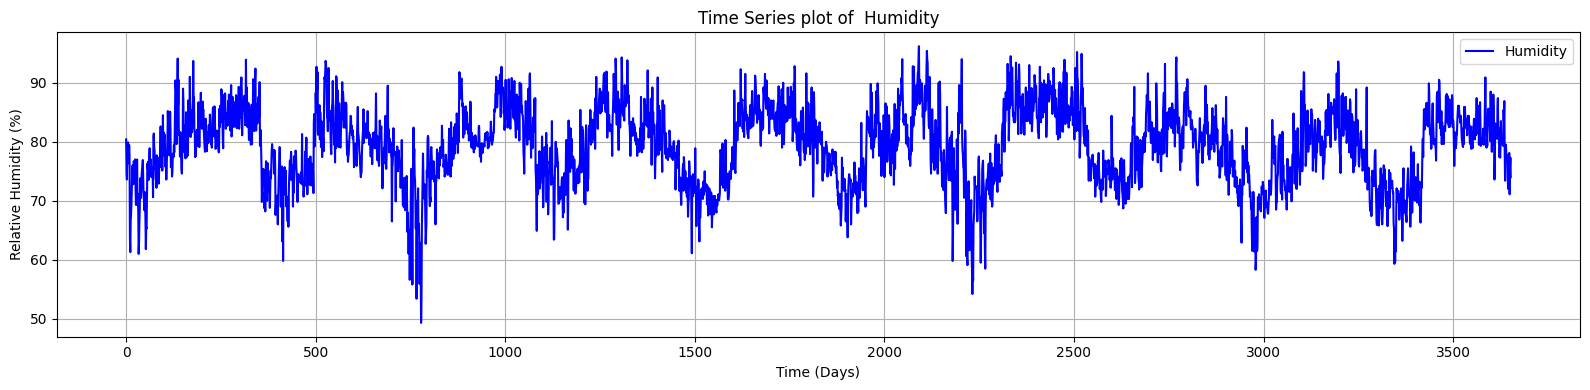

In [39]:
# Time series plot
Time_series_plot(dataset=df,
                 target_parameters=[param],
                 labels=[label],
                 y_labels=[y_label],
                 title='Time Series plot of ')

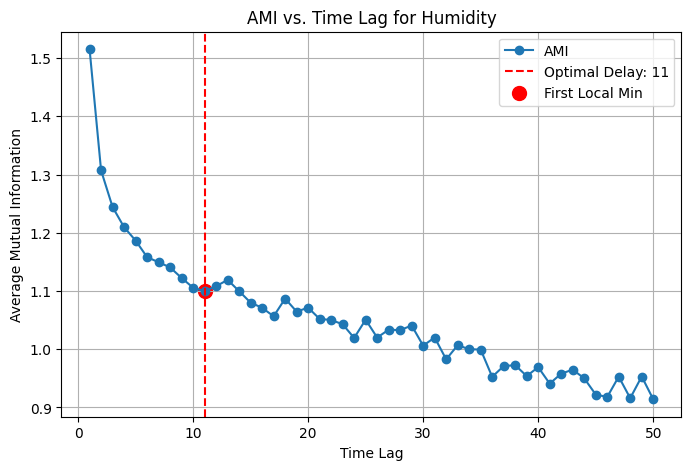


Estimated Optimal Delay Time for Humidity: 11


In [40]:
# Delay Time Estimation
hum_optimal_tau = delay_time(df, param, max_lag=50)

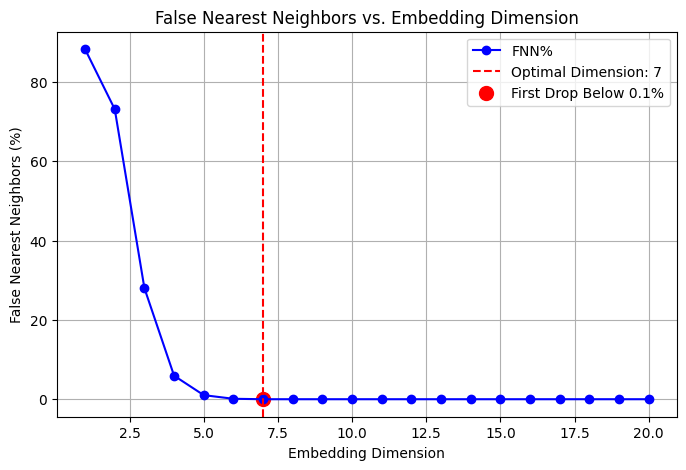

Estimated Optimal Embedding Dimension: 7


In [41]:
# Embedding Dimension Estimation
hum_optimal_m = embedding_dimension(df, param, hum_optimal_tau, max_dim=20,max_num=1000,min_val=0.1)

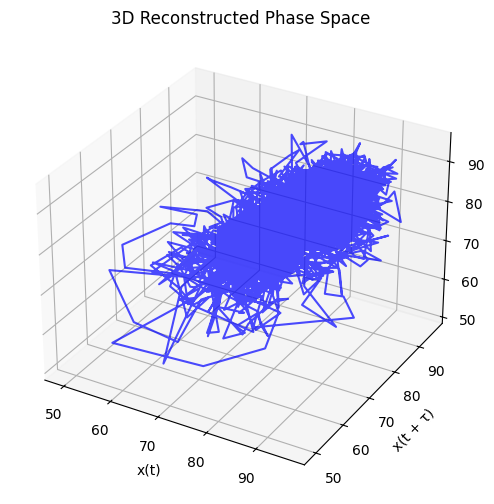

In [42]:
phase_space_reconstruction(time_series, hum_optimal_tau, hum_optimal_m)

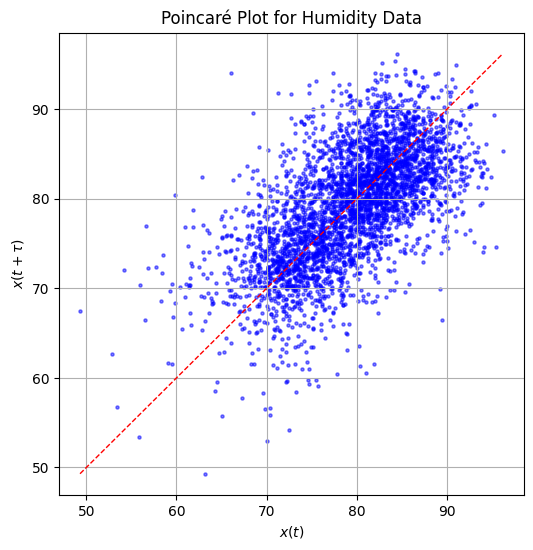

In [43]:
poincare_plot(time_series, hum_optimal_tau)

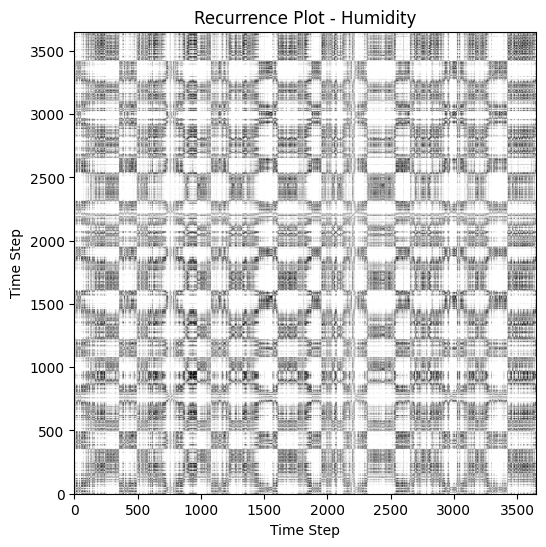

In [44]:
# Generate recurrence plots for each weather parameter
recurrence_plot(time_series, epsilon=2.5, title=f"Recurrence Plot - {label}")

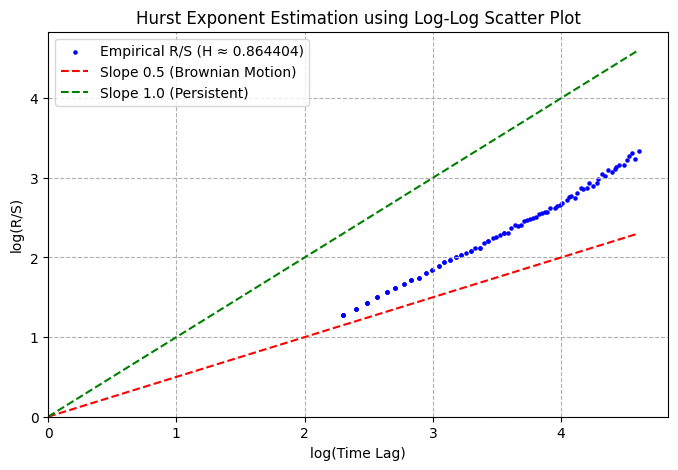

Estimated Hurst Exponent: 0.8644


In [45]:
# Compute Hurst exponent
log_lags, log_R_S, hum_H = compute_hurst_exponent(time_series)

# Plot the results
plot_hurst_exponent(log_lags, log_R_S, hum_H)

print(f"Estimated Hurst Exponent: {hum_H:.4f}")

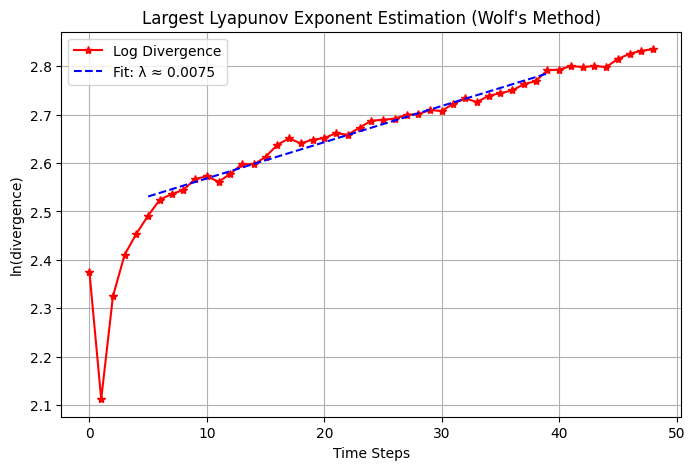

Estimated Largest Lyapunov Exponent: 0.0075


In [46]:
hum_lambda_max = compute_lyapunov_exponent_wolf(time_series, tau=hum_optimal_tau, m=hum_optimal_m, t_max=50)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


180/180 ━━━━━━━━━━━━━━━━━━━━ 21s 89ms/step - loss: 0.0796 - val_loss: 0.0073
Epoch 2/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 17s 68ms/step - loss: 0.0127 - val_loss: 0.0079
Epoch 3/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 20s 67ms/step - loss: 0.0114 - val_loss: 0.0090
Epoch 4/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 12s 68ms/step - loss: 0.0122 - val_loss: 0.0067
Epoch 5/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 20s 68ms/step - loss: 0.0114 - val_loss: 0.0062
Epoch 6/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 21s 68ms/step - loss: 0.0108 - val_loss: 0.0062
Epoch 7/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - loss: 0.0104 - val_loss: 0.0062
Epoch 8/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 21s 66ms/step - loss: 0.0097 - val_loss: 0.0061
Epoch 9/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 21s 68ms/step - loss: 0.0094 - val_loss: 0.0059
Epoch 10/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 20s 68ms/step - loss: 0.0090 - val_loss: 0.0068
Epoch 11/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 20s 65ms/step - loss: 0.0094 - val_loss: 0.0059
Epoch 12/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 

    Model Comparison for 30-Day    
            Prediction             
┏━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┓
┃ Model         ┃    MAE ┃   RMSE ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━┩
│ LSTM          │ 2.4180 │ 3.1405 │
│ Random Forest │ 2.3448 │ 3.0688 │
│ XGBoost       │ 2.6350 │ 3.3496 │
└───────────────┴────────┴────────┘

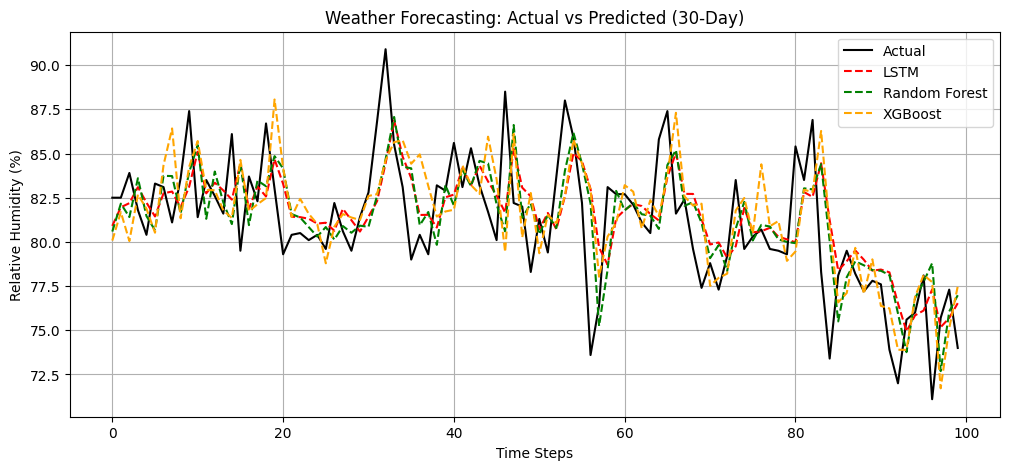

In [47]:
pred_30 = weather_forecasting(df, target_column=param,y_label=y_label, prediction_days=30, plot_days=100)

### For Wind Speed

In [48]:
param = 'windspeed'
label = 'Wind Speed'
y_label = 'Wind Speed (kph)'
time_series = df[param].dropna().values

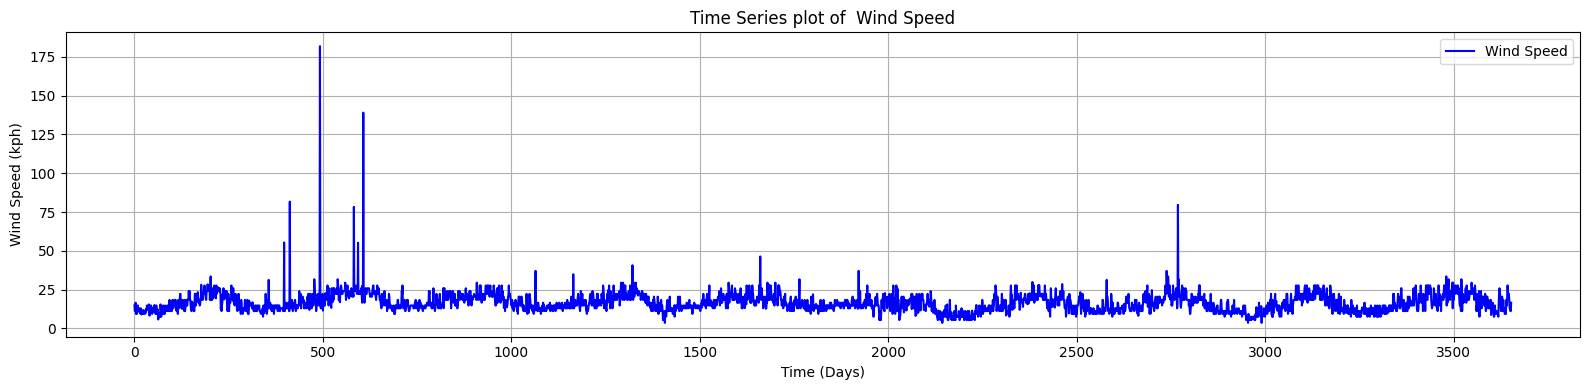

In [49]:
# Time series plot
Time_series_plot(dataset=df,
                 target_parameters=[param],
                 labels=[label],
                 y_labels=[y_label],
                 title='Time Series plot of ')

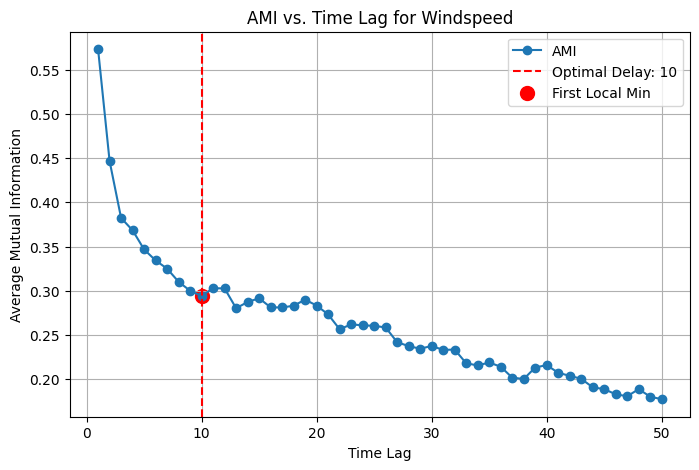


Estimated Optimal Delay Time for Windspeed: 10


In [50]:
# Delay Time Estimation
wind_optimal_tau = delay_time(df, param, max_lag=50)

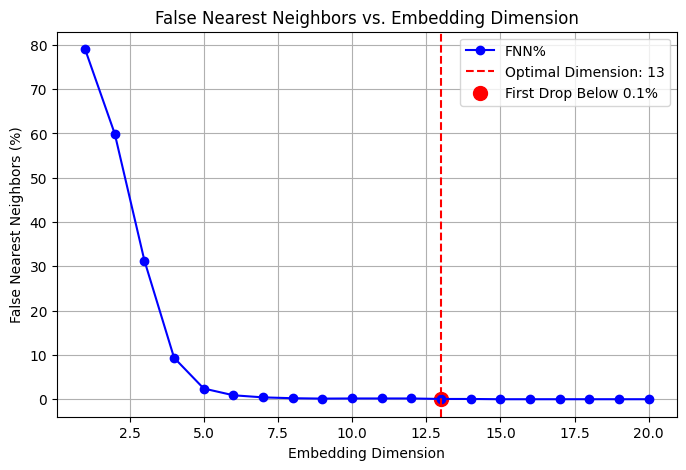

Estimated Optimal Embedding Dimension: 13


In [51]:
# Embedding Dimension Estimation
wind_optimal_m = embedding_dimension(df, param, wind_optimal_tau, max_dim=20,max_num=1000,min_val=0.1)

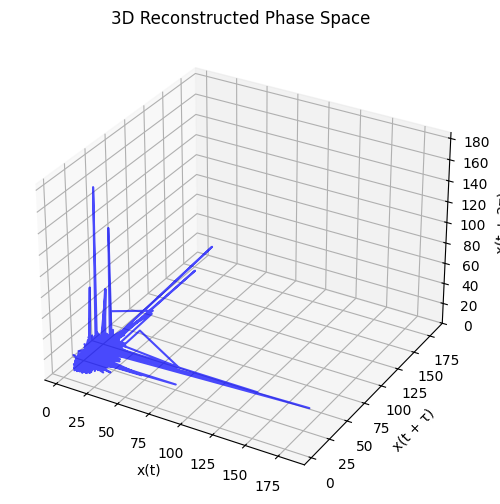

In [52]:
phase_space_reconstruction(time_series, wind_optimal_tau, wind_optimal_m)

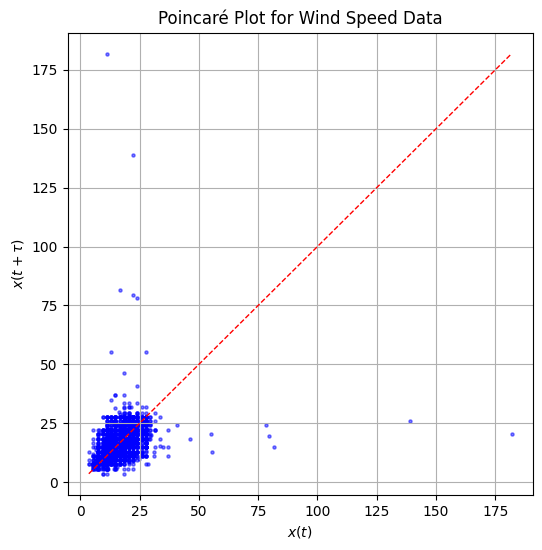

In [53]:
poincare_plot(time_series, wind_optimal_tau)

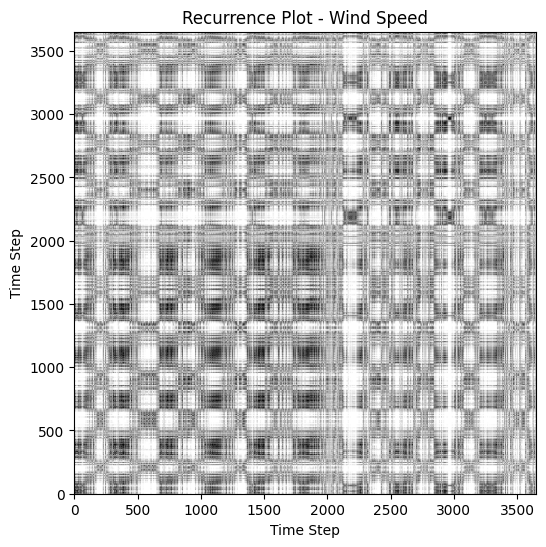

In [54]:
# Generate recurrence plots for each weather parameter
recurrence_plot(time_series, epsilon=2.5, title=f"Recurrence Plot - {label}")

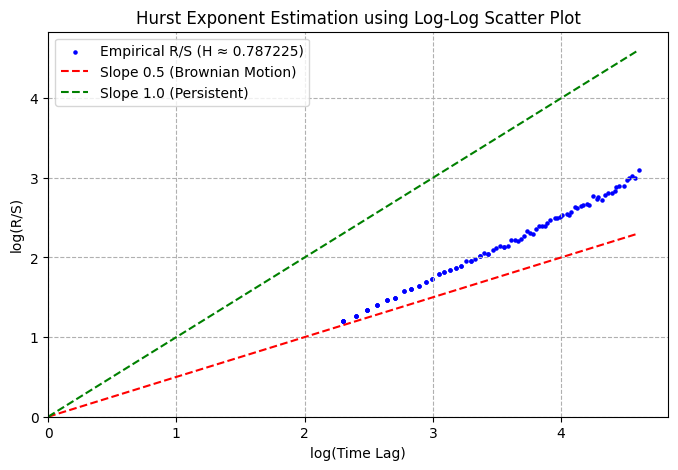

Estimated Hurst Exponent: 0.7872


In [55]:
# Compute Hurst exponent
log_lags, log_R_S, wind_H = compute_hurst_exponent(time_series)

# Plot the results
plot_hurst_exponent(log_lags, log_R_S, wind_H)

print(f"Estimated Hurst Exponent: {wind_H:.4f}")

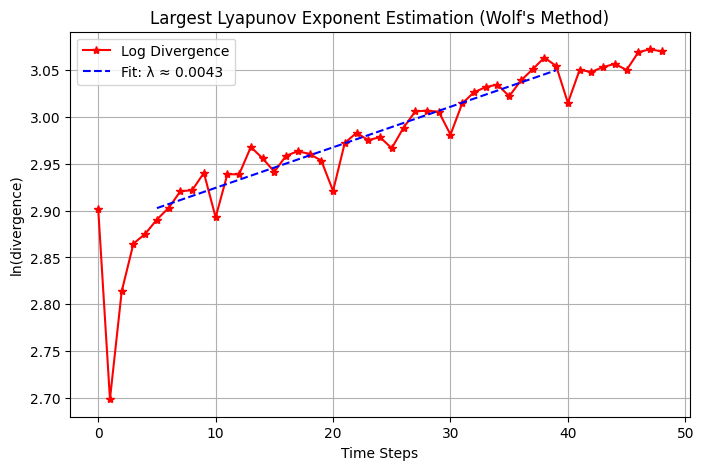

Estimated Largest Lyapunov Exponent: 0.0043


In [56]:
wind_lambda_max = compute_lyapunov_exponent_wolf(time_series, tau=wind_optimal_tau, m=wind_optimal_m, t_max=50)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


180/180 ━━━━━━━━━━━━━━━━━━━━ 17s 73ms/step - loss: 0.0018 - val_loss: 6.5280e-04
Epoch 2/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 20s 70ms/step - loss: 0.0016 - val_loss: 5.8247e-04
Epoch 3/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 20s 65ms/step - loss: 0.0011 - val_loss: 5.9542e-04
Epoch 4/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - loss: 0.0012 - val_loss: 5.5771e-04
Epoch 5/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 21s 69ms/step - loss: 0.0013 - val_loss: 5.9453e-04
Epoch 6/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 20s 69ms/step - loss: 9.0705e-04 - val_loss: 5.6166e-04
Epoch 7/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 20s 63ms/step - loss: 0.0010 - val_loss: 5.5745e-04
Epoch 8/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 21s 66ms/step - loss: 6.7105e-04 - val_loss: 5.9535e-04
Epoch 9/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step - loss: 8.5223e-04 - val_loss: 5.5445e-04
Epoch 10/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step - loss: 8.6369e-04 - val_loss: 5.9489e-04
Epoch 11/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step - loss: 9.8454e-04 

    Model Comparison for 30-Day    
            Prediction             
┏━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┓
┃ Model         ┃    MAE ┃   RMSE ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━┩
│ LSTM          │ 3.1663 │ 4.0075 │
│ Random Forest │ 3.2318 │ 4.0470 │
│ XGBoost       │ 3.4065 │ 4.4098 │
└───────────────┴────────┴────────┘

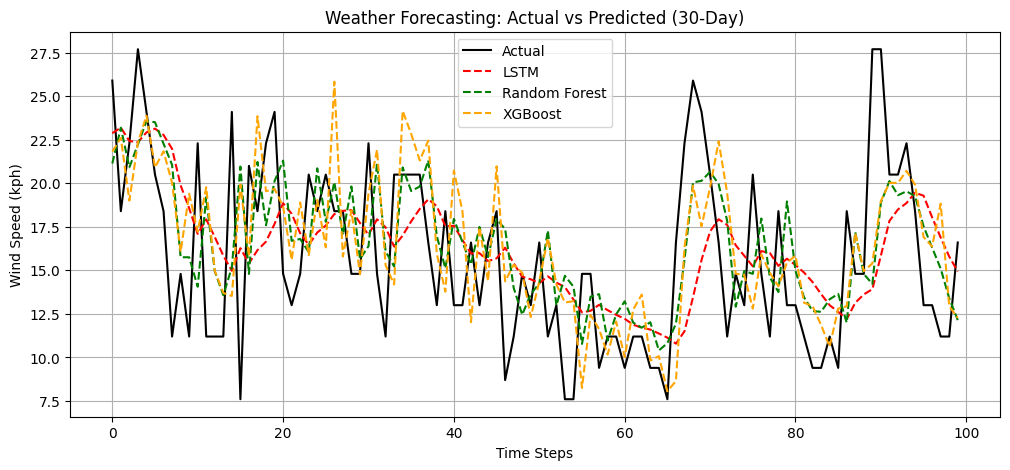

In [57]:
pred_30 = weather_forecasting(df, target_column=param,y_label=y_label, prediction_days=30, plot_days=100)

In [59]:
summary_data = [
    ("Temperature", temp_optimal_tau, temp_optimal_m, temp_lambda_max, temp_H),
    ("Humidity"   , hum_optimal_tau , hum_optimal_m , hum_lambda_max , hum_H),
    ("Wind Speed" , wind_optimal_tau, wind_optimal_m, wind_lambda_max, wind_H)
]

from tabulate import tabulate

# Convert summary data into a table
table = tabulate(summary_data, headers=["Parameter", "Optimal τ", "Optimal m", "Lyapunov Exponent (λ)", "Hurst Exponent (H)"], tablefmt="fancy_grid")

# Print the formatted table
print('Parameters for Thiruvananthapuram')
print(table)


Parameters for Thiruvananthapuram
╒═════════════╤═════════════╤═════════════╤═════════════════════════╤══════════════════════╕
│ Parameter   │   Optimal τ │   Optimal m │   Lyapunov Exponent (λ) │   Hurst Exponent (H) │
╞═════════════╪═════════════╪═════════════╪═════════════════════════╪══════════════════════╡
│ Temperature │           8 │           6 │              0.007369   │             0.855873 │
├─────────────┼─────────────┼─────────────┼─────────────────────────┼──────────────────────┤
│ Humidity    │          11 │           7 │              0.00747003 │             0.864404 │
├─────────────┼─────────────┼─────────────┼─────────────────────────┼──────────────────────┤
│ Wind Speed  │          10 │          13 │              0.0043268  │             0.787225 │
╘═════════════╧═════════════╧═════════════╧═════════════════════════╧══════════════════════╛
